## Part 2: Clinical Application

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('./datasets/crisdb/*.npz')

In [3]:
len(hr_filenames), hr_filenames

(1537,
 ['./datasets/crisdb/e026b.npz',
  './datasets/crisdb/f185b.npz',
  './datasets/crisdb/f086a.npz',
  './datasets/crisdb/m252a.npz',
  './datasets/crisdb/f177a.npz',
  './datasets/crisdb/m284a.npz',
  './datasets/crisdb/m176a.npz',
  './datasets/crisdb/e081a.npz',
  './datasets/crisdb/m195a.npz',
  './datasets/crisdb/e188b.npz',
  './datasets/crisdb/m135a.npz',
  './datasets/crisdb/m174a.npz',
  './datasets/crisdb/m234a.npz',
  './datasets/crisdb/m231a.npz',
  './datasets/crisdb/f075b.npz',
  './datasets/crisdb/e055a.npz',
  './datasets/crisdb/m035a.npz',
  './datasets/crisdb/f086b.npz',
  './datasets/crisdb/m138a.npz',
  './datasets/crisdb/m134b.npz',
  './datasets/crisdb/m292b.npz',
  './datasets/crisdb/e210a.npz',
  './datasets/crisdb/m080b.npz',
  './datasets/crisdb/e196a.npz',
  './datasets/crisdb/e235b.npz',
  './datasets/crisdb/f158b.npz',
  './datasets/crisdb/f215b.npz',
  './datasets/crisdb/e155b.npz',
  './datasets/crisdb/f013a.npz',
  './datasets/crisdb/e023a.npz',
  '

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [4]:
metadata_filename = './datasets/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

In [5]:
metadata

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male
...,...,...,...
1538,m071b,75-79,Male
1539,m163b,75-79,Male
1540,m154a,75-79,Male
1541,m158a,75-79,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [13]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    #./datasets/crisdb/e026b.npz
    subject = filename.split('/')[3][:5]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata.subject==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata.subject==subject]['sex'].values[0]

    return age_group, sex, rhr, subject

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr', 'subject'])

In [20]:
all_data = [np.load(filename) for filename in hr_filenames]
[key for key in all_data[0].keys()]

['hr']

In [11]:
df

,age_group,sex,rhr,subject
0,55-59,Male,56.947895,e026b
1,55-59,Male,55.652174,f185b
2,60-64,Male,45.714286,f086a
3,45-49,Male,59.534884,m252a
4,65-69,Male,53.706294,f177a
...,...,...,...,...
1532,55-59,Male,74.563107,m173b
1533,65-69,Male,67.378890,m267b
1534,70-74,Female,48.607595,m079b
1535,65-69,Male,62.694922,m111a


In [8]:
df[df.subject.isna()]

,age_group,sex,rhr,subject


In [9]:
df.sex.value_counts()

Male      1260
Female     277
Name: sex, dtype: int64

In [24]:
df.age_group.value_counts()

60-64    313
65-69    291
55-59    261
70-74    196
50-54    164
45-49    124
75-79     98
40-44     62
35-39     28
Name: age_group, dtype: int64

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

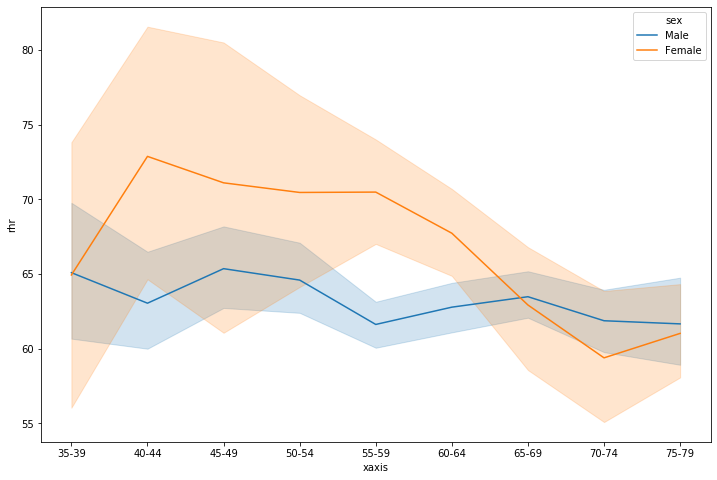

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion

> 1. For women, we see a rise in resting heart rate until ~40 which then declines until ~70 and slowly rises again.  There is a very wide range of values from the ages of ~40-60 and then variance declines again.
> 2. For men, we see a slow downtrend in heart rate which rises slightly between ages ~40 and ~60.
> 3. In comparison to men, women's heart rate has a lot more variance and range.  It also appears to be markedly higher during middle age as compared to men.    
> 4. What are some possible reasons for what we see in our data? Women and men have different aging processes and differences may be due to a combination of factors incuding endocrine, vascular, and behavioral changes amongst other variables.  Further, we have far less data for women than men from which to infer trends.
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results? It would be quite beneficial to see the diet and exercise habits regarding subjects as well as other medical variables.  This would help parse out changes due to aging or do to other lifestyle or medical changes.  Further, it would be interesting to note variance regarding other demographics such as race or socioeconomic factors.  As well, women and younger people are under-represented in the study.  A larger, more balanced dataset would benefit results.   
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age?  Not necessarily.  We are not seeing a clear rise in heart rate in the male study group, rather, it meanders slightly, going up and down, though the long view is down.  For women, we do see a marked decline after middle age, however, there is a wide variation that is not accounted for in above chart.  Of course data from survivors of myocardial infarction does not necessarily generalize to the population at large, so it would be interesting to review with a more representative sample as mentioned above.